## Урок 7

In [ ]:
#!pip install catboost
# conda install scikit-learn
# !pip install scikit-learn==0.22
# !pip install lightgbm
# !pip install xgboost
# !pip install bayesian-optimization

In [97]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
# import missingno as msno

from scipy.stats import gmean, rankdata

# plt.style.use('fivethirtyeight')
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, \
                            classification_report, plot_confusion_matrix, plot_precision_recall_curve, \
                            precision_recall_curve, recall_score, plot_roc_curve)

import xgboost as xgb
import catboost as ctb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split

### 1.Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [ ]:
# Загрузка и небольшое преобразование данных перед подачей в модель ------------------------------------------------->>>

In [2]:
my_train_old = pd.read_csv(r"./competitive-data-analysis_coursework/my_train_old.csv")
my_test_old = pd.read_csv(r"./competitive-data-analysis_coursework/my_test_old.csv")

In [4]:
my_train_old.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
3,123710391,1,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
  
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict_proba(x_train)
        y_valid_pred = estimator.predict_proba(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred[:,1]))
        fold_valid_scores.append(metric(y_valid, y_valid_pred[:,1]))
        oof_predictions[valid_idx] = y_valid_pred[:,1]

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")
    
    print(estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions)
    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [26]:
import time
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=75,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=100,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [7]:
X = my_train_old.drop("TARGET", axis=1)
y = my_train_old["TARGET"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=99)

In [ ]:
# Модель lgbm

In [16]:
lgbm_params = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
     'n_estimators': 1500,
      'learning_rate': 0.06,
    'max_depth': 3,
    'min_child_weight': 114,
    'num_leaves': 132,
    'reg_alpha': 0.04,
    'reg_lambda': 0.01,
    'subsample': 0.3, 
    'random_state': 99,
#     "early_stopping_rounds": 25
}

In [17]:
model_lgbm = LGBMClassifier(**lgbm_params)
model_lgbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=200)

[200]	training's auc: 0.73879	valid_1's auc: 0.722267
[400]	training's auc: 0.749862	valid_1's auc: 0.72509
[600]	training's auc: 0.757739	valid_1's auc: 0.726673
[800]	training's auc: 0.76357	valid_1's auc: 0.726769
[1000]	training's auc: 0.769156	valid_1's auc: 0.72603
[1200]	training's auc: 0.773435	valid_1's auc: 0.726082
[1400]	training's auc: 0.777771	valid_1's auc: 0.725337
[1600]	training's auc: 0.781726	valid_1's auc: 0.724796


LGBMClassifier(learning_rate=0.05, max_depth=3, metric='auc',
               min_child_weight=114, n_estimators=1631, num_leaves=132,
               random_state=99, reg_alpha=0.04813, reg_lambda=0.0162,
               subsample=0.3)

In [19]:
def lgbm_optimize_params(n_estimators, max_depth, learning_rate, num_leaves, reg_alpha, reg_lambda, min_child_weight, subsample):
    lgbm_params["n_estimators"]= int(n_estimators)
    lgbm_params["max_depth"] = int(max_depth)
    lgbm_params["learning_rate"] = learning_rate
    lgbm_params["num_leaves"] = int(num_leaves)
    lgbm_params["reg_alpha"] = reg_alpha
    lgbm_params["reg_lambda"] = reg_lambda
    lgbm_params["min_child_weight"] = min_child_weight
    lgbm_params["subsample"] = subsample
          
    model_lgbm = LGBMClassifier(**lgbm_params)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

    return roc_auc_score(y_valid, model_lgbm.predict_proba(X_valid)[:,1])

lgbm_params_search = BayesianOptimization(
    f=lgbm_optimize_params,
    pbounds={
        "n_estimators": (1500, 2000),
        "max_depth": (3, 4),
        'learning_rate': (0.03, 0.04),
        "num_leaves": (120, 135),
        "reg_alpha": (0.0, 0.085),
        "reg_lambda": (0.04, 0.099),
        'min_child_weight': (115, 120),
        'subsample': (0.3, 0.4),

    },
    random_state=99)

lgbm_params_search.maximize(init_points=10, n_iter=3, acq='ei')

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7249   |  0.03672  |  3.488    |  119.1    |  1.516e+0 |  132.1    |  0.04808  |  0.05756  |  0.3047   |
|  2        |  0.7247   |  0.03991  |  3.007    |  118.8    |  1.873e+0 |  125.7    |  0.042    |  0.09481  |  0.3395   |
|  3        |  0.7245   |  0.03974  |  3.524    |  115.5    |  1.907e+0 |  123.2    |  0.04712  |  0.05724  |  0.3816   |
|  4        |  0.7256   |  0.03828  |  3.222    |  118.2    |  1.548e+0 |  126.2    |  0.008234 |  0.0485   |  0.3212   |
|  5        |  0.7254   |  0.03477  |  3.078    |  116.2    |  1.503e+0 |  133.5    |  0.04694  |  0.04989  |  0.3929   |
|  6        |  0.725    |  0.03542  |  3.042    |  117.6    |  1.82e+03 |  132.0    |  0.07097  |  0.05491  |  0.3968   |
|  7        |  0.7256   

In [22]:
cv_strategy = KFold(n_splits=10)
# random_state=99, shuffle=True

estimators_lgbm, oof_score_lgbm, fold_train_scores_lgbm, fold_valid_scores_lgbm, oof_predictions_lgbm = make_cross_validation(
    my_train_old.drop('TARGET', axis=1), my_train_old['TARGET'], model_lgbm, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7749, valid-score = 0.7212
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7735, valid-score = 0.733
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7753, valid-score = 0.7137
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7736, valid-score = 0.728
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7724, valid-score = 0.7388
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7718, valid-score = 0.7319
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.773, valid-score = 0.7278
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7727, valid-score = 0.7203
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7733, valid-score = 0.7362
Fold: 10, train-observations = 99084, va

In [ ]:
# sample_submit = pd.read_csv(r"./competitive-data-analysis_coursework/sample_submit.csv")
# sample_submit['TARGET'] = estimators_lgbm[9].predict_proba(my_test_old)[:,1].tolist()
# sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kag_lite51.csv", index=False)
# sample_submit

In [ ]:
# результат model_lgbm на лидерборде kaggle составил 0.728

In [ ]:
# Модель XGBoost

In [76]:
xgb_params = {
#     "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "nthread": 10,
    "seed": 99,
    'colsample_bytree': 0.9,
    'learning_rate': 0.4,
    'max_depth': 3,
    'min_child_weight': 100,
#     'reg_alpha': 0.0452,
    'reg_lambda': 0.09,
#     'subsample': 0.69
}


dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)

model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
    early_stopping_rounds=25,
    num_boost_round=2000,
    verbose_eval=500,
    maximize=True,
)

[0]	dtrain-auc:0.63392	dvalid-auc:0.62680
[215]	dtrain-auc:0.76109	dvalid-auc:0.73007


In [77]:
def xgboost_optimize_params(learning_rate, min_child_weight, subsample, colsample_bytree, reg_lambda):
#     xgb_params["num_boost_round"] = int(num_boost_round) 
#     xgb_params["max_depth"] = int(max_depth)
    xgb_params["learning_rate"] = learning_rate
    xgb_params["min_child_weight"] = int(min_child_weight)
    xgb_params["subsample"] = subsample
    xgb_params["colsample_bytree"] = colsample_bytree
#     xgb_params["reg_alpha"] = reg_alpha
    xgb_params["reg_lambda"] = reg_lambda

    model_xgb = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
        early_stopping_rounds=75,
        num_boost_round=2000,
        verbose_eval=False,
        maximize=True,
    )

    return roc_auc_score(y_valid, model_xgb.predict(dvalid))

In [78]:
xgb_params_search = BayesianOptimization(
    xgboost_optimize_params,
    pbounds={
#         "num_boost_round": (500, 3500),
#         "max_depth": (2, 3),
        "learning_rate": (0.3, 0.9),
         "min_child_weight": (350, 500),
        'subsample': (0.2, 0.9),
        "colsample_bytree": (0.6, 0.7),
#         "reg_alpha": (0.03, 0.09),
        "reg_lambda": (0.03, 0.09),
        
},
    random_state=99)

xgb_params_search.maximize(init_points=10, n_iter=3, acq='ei')

|   iter    |  target   | colsam... | learni... | min_ch... | reg_la... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.7195   |  0.6672   |  0.5928   |  473.8    |  0.03189  |  0.7656   |
|  2        |  0.6981   |  0.6566   |  0.4786   |  357.0    |  0.08944  |  0.2048   |
|  3        |  0.7212   |  0.677    |  0.7481   |  406.6    |  0.05965  |  0.8503   |
|  4        |  0.719    |  0.6395   |  0.8844   |  428.7    |  0.03562  |  0.7693   |
|  5        |  0.7219   |  0.6212   |  0.6326   |  393.8    |  0.07897  |  0.7796   |
|  6        |  0.7019   |  0.6222   |  0.6869   |  364.3    |  0.0547   |  0.2678   |
|  7        |  0.7183   |  0.6144   |  0.4273   |  421.5    |  0.03466  |  0.3645   |
|  8        |  0.7198   |  0.6007   |  0.8392   |  432.8    |  0.04005  |  0.8502   |
|  9        |  0.725    |  0.6542   |  0.3251   |  428.7    |  0.06841  |  0.7605   |
|  10       |  0.713    |  0.6835   |  0.4516   |  495

In [79]:
cv_strategy = KFold(n_splits=10)

xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    xgb_params, my_train_old.drop('TARGET', axis=1), my_train_old['TARGET'], cv_strategy
)

Thu Oct 28 21:02:38 2021, Cross-Validation, 110093 rows, 29 cols
[0]	train-auc:0.62830	valid-auc:0.61411
[100]	train-auc:0.73403	valid-auc:0.70883
[200]	train-auc:0.74137	valid-auc:0.71316
[300]	train-auc:0.74691	valid-auc:0.71431
[400]	train-auc:0.75052	valid-auc:0.71590
[500]	train-auc:0.75438	valid-auc:0.71742
[534]	train-auc:0.75537	valid-auc:0.71643
Fold 1, Valid score = 0.71643
[0]	train-auc:0.62713	valid-auc:0.63553
[100]	train-auc:0.73276	valid-auc:0.72714
[168]	train-auc:0.73818	valid-auc:0.72781
Fold 2, Valid score = 0.72781
[0]	train-auc:0.62903	valid-auc:0.61471
[100]	train-auc:0.73485	valid-auc:0.71201
[200]	train-auc:0.74242	valid-auc:0.71628
[287]	train-auc:0.74704	valid-auc:0.71649
Fold 3, Valid score = 0.71669
[0]	train-auc:0.63217	valid-auc:0.62683
[100]	train-auc:0.73293	valid-auc:0.72430
[200]	train-auc:0.74084	valid-auc:0.72622
[274]	train-auc:0.74418	valid-auc:0.72558
Fold 4, Valid score = 0.72558
[0]	train-auc:0.63149	valid-auc:0.65098
[100]	train-auc:0.73194	val

In [100]:
dtest = xgb.DMatrix(my_test_old)

In [ ]:
# sample_submit = pd.read_csv(r"./competitive-data-analysis_coursework/sample_submit.csv")
# sample_submit['TARGET'] = xgb_estimators[9].predict(dtest).tolist()
# sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kag_lite52.csv", index=False)
# sample_submit

In [ ]:
# результат model_xgb на лидерборде kaggle составил 0.72506

In [82]:
scores = pd.DataFrame({
    "lgbm": oof_predictions_lgbm,
    "xgb": xgb_oof,
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

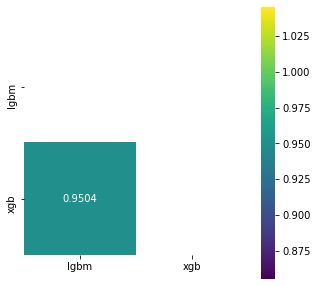

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Корреляция не сильная(сильная 0,97+), поэтому это предположительно может дать повышение качества при том, что качество каждой модели будет примерно одинаково.

### 2.Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [84]:
# AMean
scores_mean_am = scores.mean(axis=1)
score_am = roc_auc_score(my_train_old['TARGET'], scores_mean_am)
print(f"Score = {round(score_am, 4)}")

# 0.6*best + 0.4*(best-1)
# scipy.optimize

Score = 0.7302


In [85]:
# GMean
scores_mean_gm = gmean(scores, axis=1)
score_gm = roc_auc_score(my_train_old['TARGET'], scores_mean_gm)
print(f"Score = {round(score_gm, 4)}")

Score = 0.7302


In [86]:
# Rankdata
# ROC-AUC / GINI
scores_mean_rg = scores.rank().mean(axis=1)
score_rg = roc_auc_score(my_train_old['TARGET'], scores_mean_rg)
print(f"Score = {round(score_rg, 4)}")

Score = 0.7296


In [87]:
# Rankdata
scores_mean_rd = gmean(scores.rank(), axis=1)
score_rd = roc_auc_score(my_train_old['TARGET'], scores_mean_rd)
print(f"Score = {round(score_rd, 4)}")

Score = 0.7295


Качество комбинации немного увеличилось, корреляция между моделями не сильная, что позволило увеличить общее качество(каждая из 2 моделей хуже комбинации).

### 3.Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

In [14]:
params_ctb3 = {
    "silent": True,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "early_stopping_rounds": 55,
    "random_state": 99,
    'learning_rate': 0.05,
    'max_bin': 158,
    'min_child_samples': 234.79662806085997,
    'n_estimators': 1552,
    'thread_count': 28
}

In [15]:
model_ctb_old = CatBoostClassifier(**params_ctb3)
model_ctb_old.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=200)

0:	test: 0.5055865	test1: 0.5061707	best: 0.5061707 (0)	total: 18.2ms	remaining: 1m 23s
200:	test: 0.7113879	test1: 0.7082072	best: 0.7082072 (200)	total: 8.2s	remaining: 2m 57s
400:	test: 0.7208276	test1: 0.7193361	best: 0.7193361 (400)	total: 16.2s	remaining: 2m 47s
600:	test: 0.7263921	test1: 0.7222402	best: 0.7224618 (575)	total: 24.1s	remaining: 2m 38s
800:	test: 0.7301950	test1: 0.7240537	best: 0.7241173 (798)	total: 32s	remaining: 2m 29s
1000:	test: 0.7333180	test1: 0.7257342	best: 0.7257729 (997)	total: 39.8s	remaining: 2m 21s
1200:	test: 0.7357734	test1: 0.7268440	best: 0.7269146 (1171)	total: 47.7s	remaining: 2m 13s
1400:	test: 0.7378336	test1: 0.7270844	best: 0.7271319 (1357)	total: 55.7s	remaining: 2m 5s
1600:	test: 0.7397340	test1: 0.7278132	best: 0.7278325 (1596)	total: 1m 3s	remaining: 1m 57s
1800:	test: 0.7414503	test1: 0.7282369	best: 0.7282369 (1800)	total: 1m 11s	remaining: 1m 49s
2000:	test: 0.7431165	test1: 0.7286078	best: 0.7286321 (1937)	total: 1m 19s	remaining: 

In [ ]:
def catboost_old_optimize_params(n_estimators, max_depth, learning_rate, l2_leaf_reg, max_bin, thread_count):
    params_ctb2["n_estimators"]= int(n_estimators)
    params_ctb2["max_depth"] = int(max_depth)
    params_ctb2["learning_rate"] = learning_rate
    params_ctb2["l2_leaf_reg"]= int(l2_leaf_reg)
    params_ctb2["max_bin"]= int(max_bin)
    params_ctb2["thread_count"]= int(thread_count)
    params_ctb2["min_child_samples"]= int(min_child_samples)
    params_ctb2["subsample"] = subsample

    model_ctb_old = CatBoostClassifier(**params_ctb2)
    model_ctb_old.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)])

    return roc_auc_score(y_valid, model_ctb_old.predict_proba(X_valid)[:,1])

In [ ]:
#!pip install scikit-learn==0.22 ,если будет выдать ошибку типа найдены NaN или inf(беск-сть), на версии 0,22 должно заработать!
ctb_params_search = BayesianOptimization(
    f=catboost_old_optimize_params,
    pbounds={
        "n_estimators": (1000, 2000),
        "max_depth": (2, 8),
        'learning_rate': (0.01, 0.5),
        "l2_leaf_reg": (150, 300),
        "max_bin": (100, 350),
        "thread_count": (10, 30),
    
    },
    random_state=99
)

ctb_params_search.maximize(init_points=10, n_iter=3, acq='ei')

In [88]:
cv_strategy = KFold(n_splits=10)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    my_train_old.drop('TARGET', axis=1), my_train_old['TARGET'], model_ctb_old, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7521, valid-score = 0.7199
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7507, valid-score = 0.735
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7524, valid-score = 0.7207
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7513, valid-score = 0.7323
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7513, valid-score = 0.7396
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7507, valid-score = 0.7302
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7509, valid-score = 0.7335
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7518, valid-score = 0.7223
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7514, valid-score = 0.7354
Fold: 10, train-observations = 99084, 

In [107]:
scores = pd.DataFrame({
    "lgbm": oof_predictions_lgbm,
    "xgb": xgb_oof,
    "ctb": oof_predictions
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

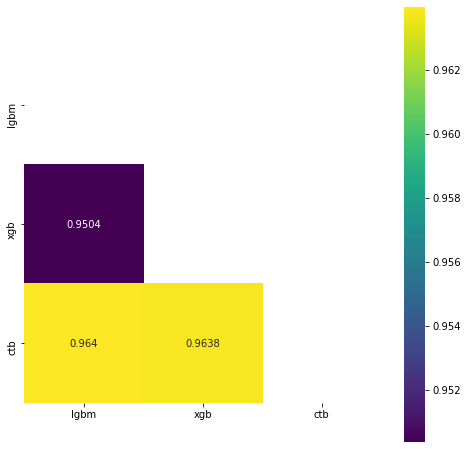

In [108]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Корреляция близка к высокой, однако все еще возможно улучшение качества комбинации моделей.

### 4.Выполнить задание 2 для трех моделей.

In [93]:
# AMean
scores_mean_am = scores.mean(axis=1)
score_am = roc_auc_score(my_train_old['TARGET'], scores_mean_am)
print(f"Score = {round(score_am, 4)}")


Score = 0.7312


In [94]:
# GMean
scores_mean_gm = gmean(scores, axis=1)
score_gm = roc_auc_score(my_train_old['TARGET'], scores_mean_gm)
print(f"Score = {round(score_gm, 4)}")

Score = 0.7312


In [95]:
# Rankdata
# ROC-AUC / GINI
scores_mean_rg = scores.rank().mean(axis=1)
score_rg = roc_auc_score(my_train_old['TARGET'], scores_mean_rg)
print(f"Score = {round(score_rg, 4)}")

Score = 0.7308


In [96]:
# Rankdata
scores_mean_rd = gmean(scores.rank(), axis=1)
score_rd = roc_auc_score(my_train_old['TARGET'], scores_mean_rd)
print(f"Score = {round(score_rd, 4)}")

Score = 0.7307


Видно, что результат значительно улучшился. Улучшение произошло благодаря схожести моделей на качеству и отсутствию высокой корреляции моделей (высокая 0.97+). 